In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart.csv')

In [3]:
# Step 1: Filter dataset for Store 1
store_1_df = df[df['Store'] == 1]

In [9]:
# Convert the date column to datetime
store_1_df['Date'] = pd.to_datetime(store_1_df['Date'], dayfirst = True)

C:\Users\kunal\AppData\Local\Temp\ipykernel_18536\1745941358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_1_df['Date'] = pd.to_datetime(store_1_df['Date'], dayfirst = True)


In [10]:
# Step 3: Rename columns
store_1_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

C:\Users\kunal\AppData\Local\Temp\ipykernel_18536\2840147686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_1_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)


In [11]:
store_1_df

,Store,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573


In [12]:
from prophet import Prophet

# Step 4: Train the Prophet model
prophet_model = Prophet(
    changepoint_prior_scale=0.5,  # Adjust changepoint prior scale
    seasonality_prior_scale=10.0,  # Adjust seasonality prior scale
    holidays_prior_scale=10.0,  # Adjust holidays prior scale
    yearly_seasonality=True,  # Include yearly seasonality
)
prophet_model.fit(store_1_df)

15:13:30 - cmdstanpy - INFO - Chain [1] start processing
15:13:30 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Step 5: Make predictions for the next 1 year
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

In [14]:
# Step 6: Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

actual_values = store_1_df['y']
predicted_values = forecast['yhat'][:len(actual_values)]

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mse)

In [15]:
# Additional metrics
residuals = actual_values - predicted_values
mas = (residuals.abs() / actual_values).mean()
r2 = r2_score(actual_values, predicted_values)

# Print evaluation metrics
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Scaled Error:', mas)
print('R^2 Score:', r2)

Mean Absolute Error: 75542.20235706134
Mean Squared Error: 11335496816.87365
Root Mean Squared Error: 106468.29019418715
Mean Absolute Scaled Error: 0.047602255393065236
R^2 Score: 0.5308128113099679


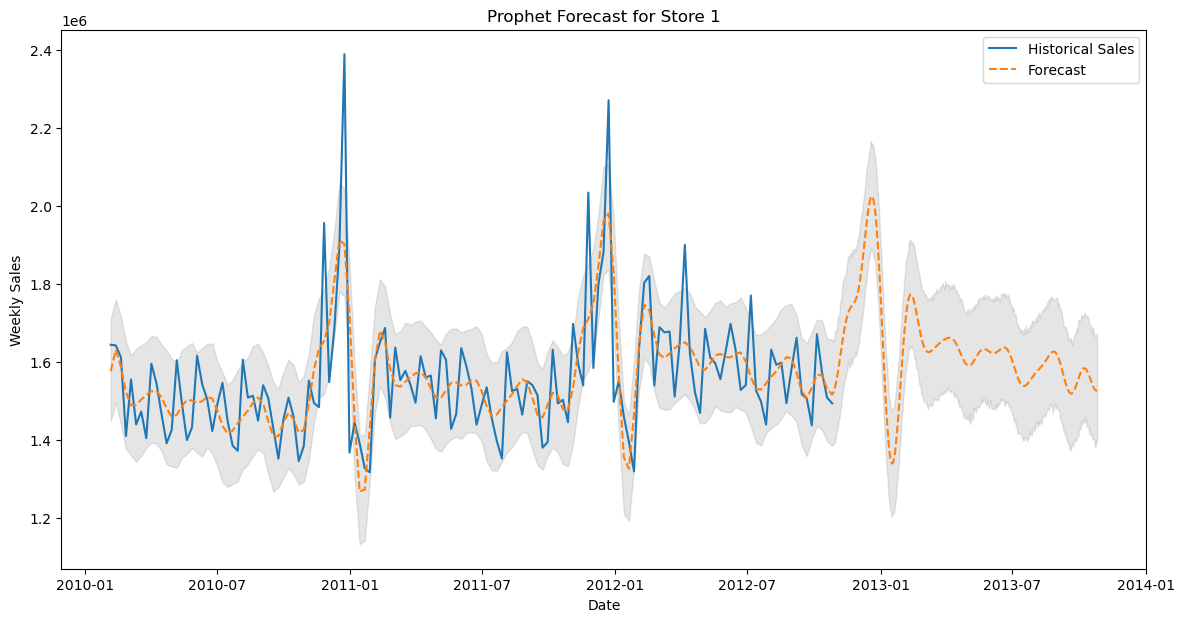

In [16]:
# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(store_1_df['ds'], store_1_df['y'], label='Historical Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Prophet Forecast for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [17]:
# Function to train Prophet model and make predictions for each store
def predict_for_all_stores(df):
    forecasts = []
    for store_id in range(1, 46):  # Assuming store IDs range from 1 to 45
        # Filter data for the current store
        store_df = df[df['Store'] == store_id].copy()  # Ensure a copy of the DataFrame is made
        # Convert date column to datetime
        store_df['Date'] = pd.to_datetime(store_df['Date'], dayfirst=True)
        # Rename columns for Prophet
        store_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
        
        # Train Prophet model
        prophet_model = Prophet()
        prophet_model.fit(store_df)
        
        # Make future dataframe for predictions
        future = prophet_model.make_future_dataframe(periods=365)  # Predict for the next 1 year
        
        # Predict sales
        forecast = prophet_model.predict(future)
        forecast['Store'] = store_id  # Add store ID to the forecast DataFrame
        forecasts.append(forecast)
    
    return forecasts

# Call the function to get forecasts for all stores
forecasts_all_stores = predict_for_all_stores(df)

# Concatenate forecasts for all stores into a single DataFrame
all_stores_forecast_df = pd.concat(forecasts_all_stores)


15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:04 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1] done processing
15:14:04 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1] done processing
15:14:04 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1] done processing
15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:05 - cmdstanpy - INFO - Chain [1] done processing
15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:05 - cmdstanpy - INFO - Chain [1] done processing
15:14:06 - cmdstanpy - INFO - Chain [1] start processing
15:14:06 - cmdstanpy - INFO - Chain [1]

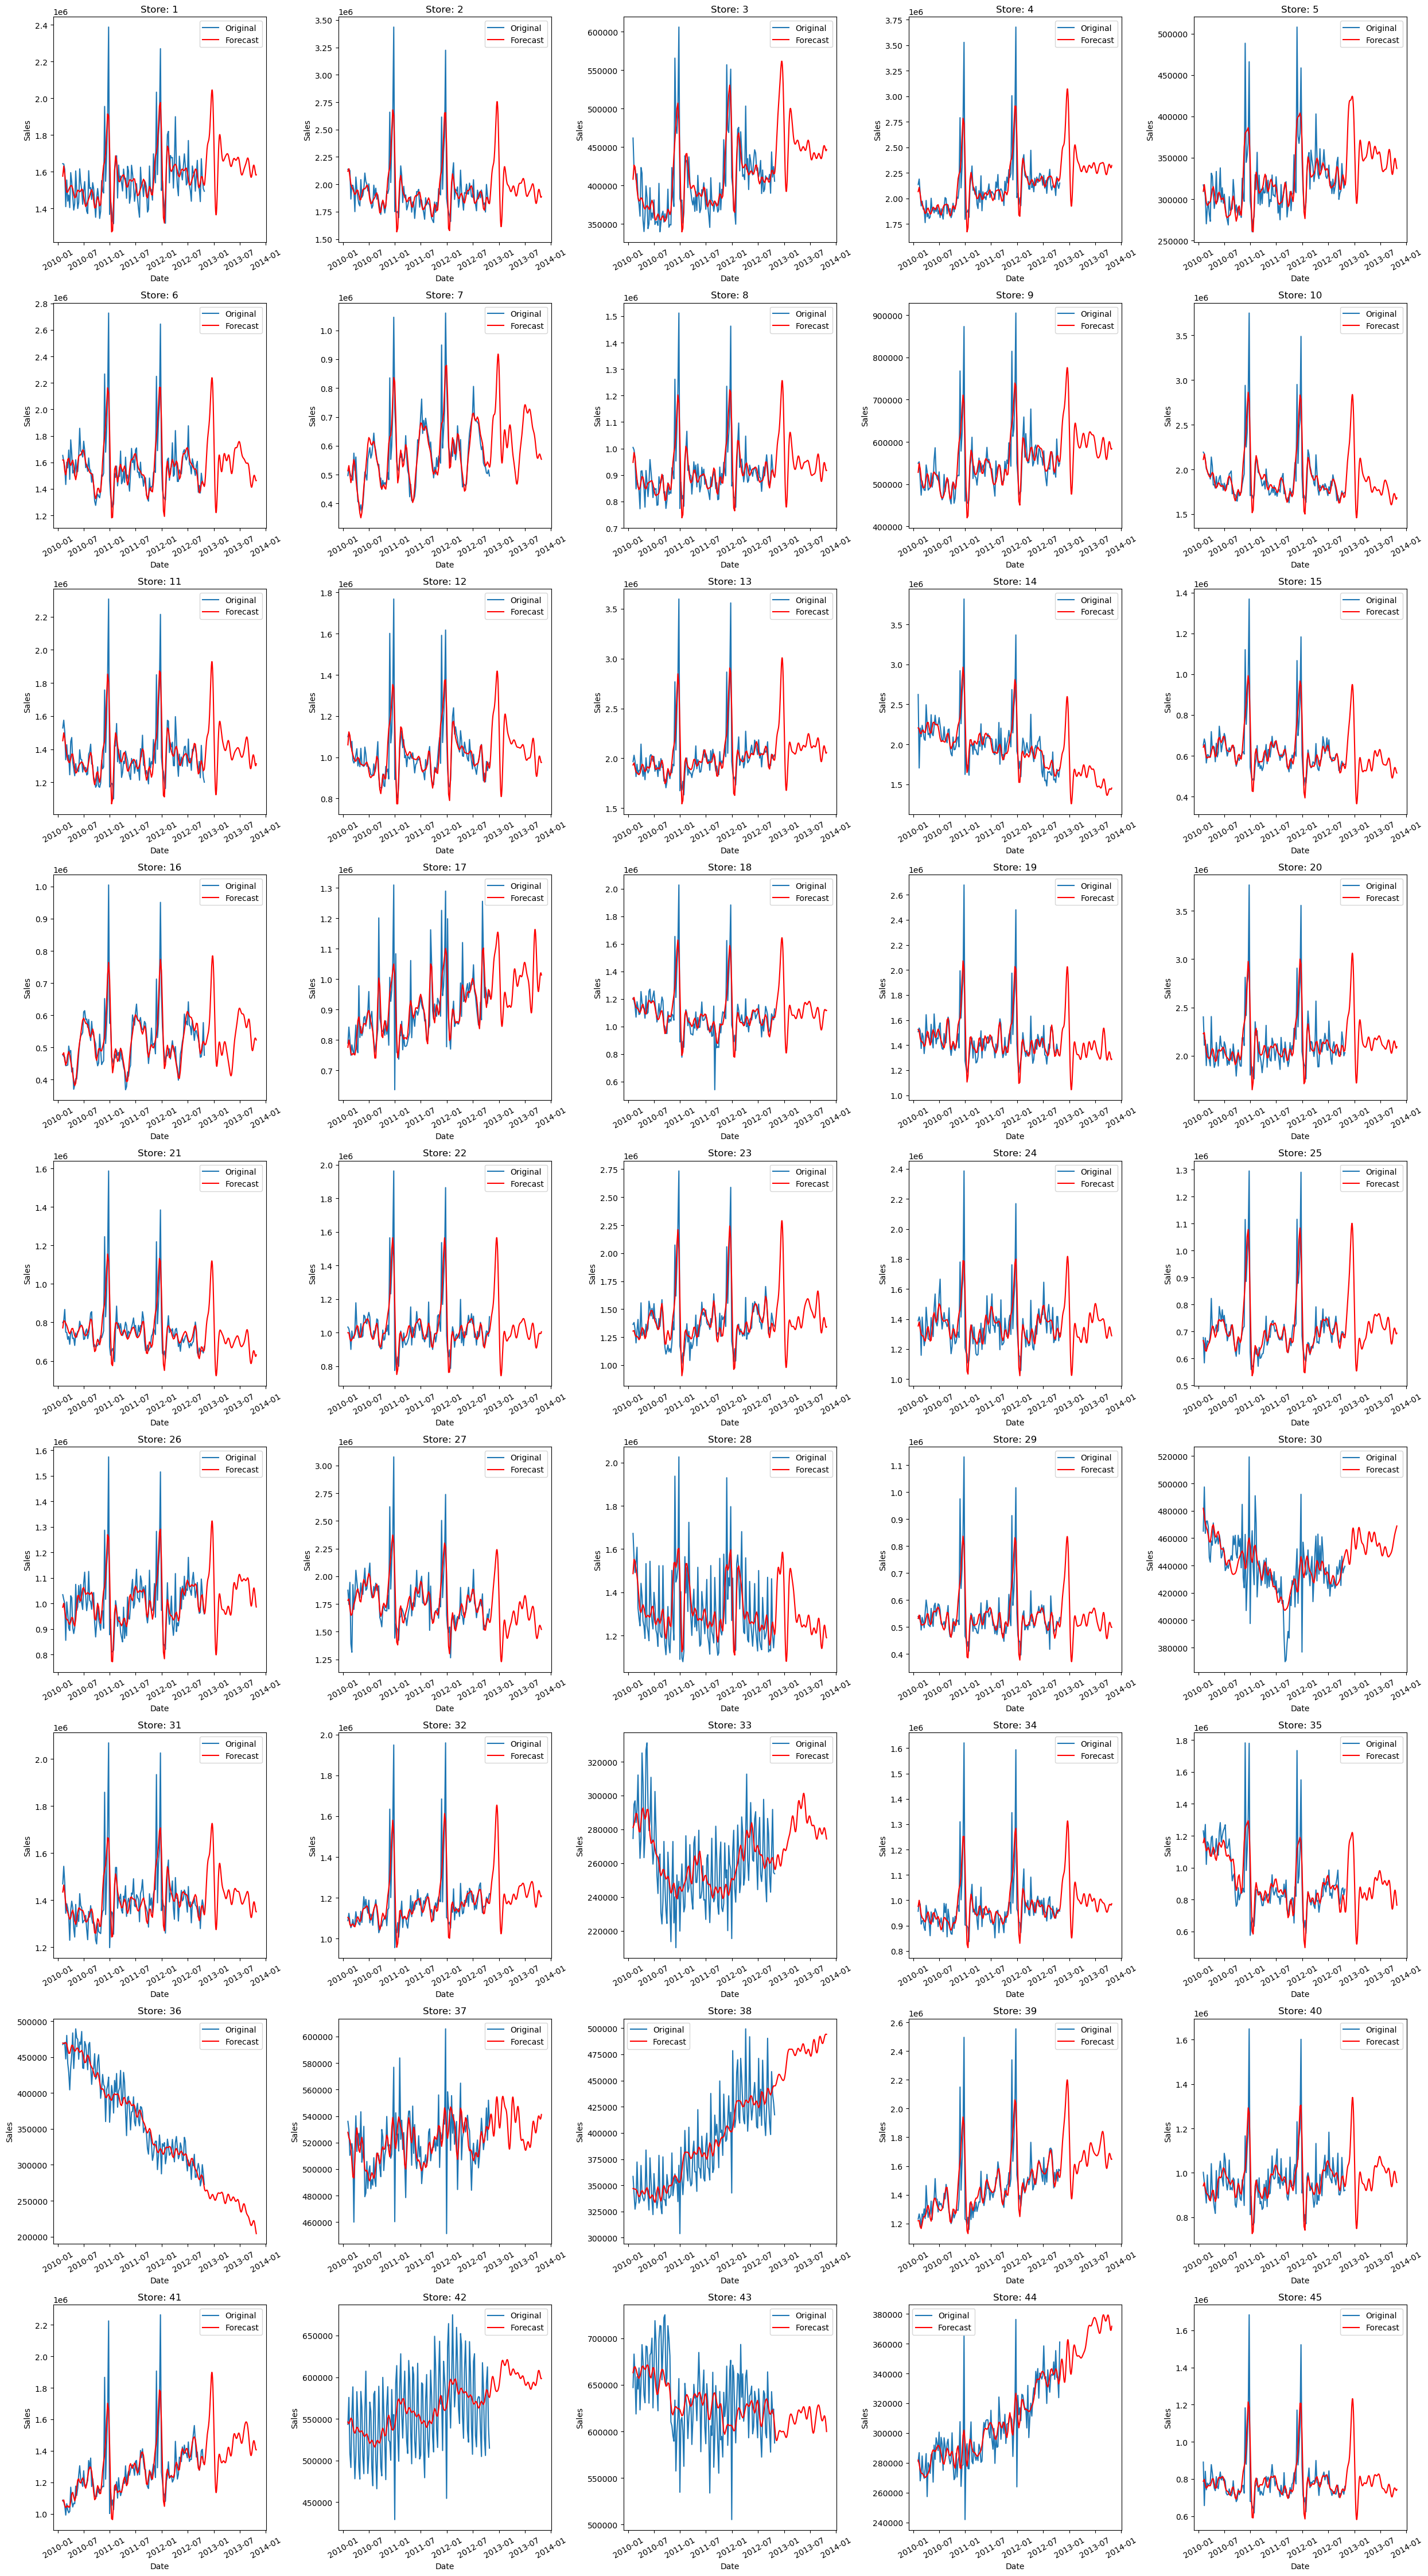

In [19]:
plt.subplots(9, 5, figsize=(25, 45))

for i in range(1, 46):
    store_forecast = all_stores_forecast_df[all_stores_forecast_df['Store'] == i]
    
    # Get original weekly sales data for the current store
    original_sales_data = df[df['Store'] == i].copy()  # 
    original_sales_data['Date'] = pd.to_datetime(original_sales_data['Date'], dayfirst=True)  # Convert to datetime
    
    plt.subplot(9, 5, i)
    plt.plot(original_sales_data['Date'], original_sales_data['Weekly_Sales'], label='Original')
    plt.plot(store_forecast['ds'], store_forecast['yhat'], label='Forecast', color='red')
    plt.title(f'Store: {i}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()
